Librerias a utilizar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
#from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset
#from torchvision import models
import torch.optim as optim
import time
import copy
from glob import glob

Atributos

In [2]:
CANTIDAD_CLASES = 4
#ANCHO_IMAGENES = 299 para red inception
#ALTO_IMAGENES = 299  para red inception

In [3]:
 #modelo pre-cargado Inception V3
model_inception = models.inception_v3(pretrained=True)
model_inception.parameters


c:\ProgramData\anaconda3\envs\CUDA_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\CUDA_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.parameters of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2

In [5]:
#Definiendo modelo.
#congelando capas y modificando la ultima 
learning_rate=1e-5
def get_model():
    model = models.inception_v3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128,6))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
    return model.to(device), loss_fn, optimizer

In [6]:
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_shape = (3,299,299)
summary(model_inception.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [7]:
train_data_dir = "Dataset_Splitted_/train"
test_data_dir = "Dataset_Splitted_/test"
pred_data_dir = "Dataset_Splitted_/val"

In [8]:
#Verificando cantidad de imagenes de training

for i in os.listdir(train_data_dir):
    new_loc = os.path.join(train_data_dir,i)
    new = new_loc + '/*.jpg'
    images = glob(new)
    print(f'{i}:',len(images))

Blight: 916
Common_Rust: 1044
Gray_Leaf_Spot: 459
Healthy: 929


In [9]:
#Verificando cantidad de imagenes de test

for i in os.listdir(test_data_dir):
    new_loc = os.path.join(test_data_dir,i)
    new = new_loc + '/*.jpg'
    images = glob(new)
    print(f'{i}:',len(images))

Blight: 116
Common_Rust: 132
Gray_Leaf_Spot: 58
Healthy: 117


In [10]:
# obteniendo el tipo de clases
classes = os.listdir(train_data_dir)
classes = {k: v for k,v in enumerate(sorted(classes))}
print(classes)

{0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}


In [11]:
#Transformacion y data augmentation

transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomResizedCrop(size=(299, 299), scale=(0.5, 1.0)),
    transforms.ColorJitter(saturation=0.1, hue=0.1),
    transforms.ToTensor()

])

# Augmentation no es necesario para test y val
transform_val = torchvision.transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor()
       ])

transform_tests = torchvision.transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor()

    ])

In [27]:
# Dataloader
train_data = datasets.ImageFolder(root=train_data_dir,transform=transform)
test_data = datasets.ImageFolder(root=pred_data_dir,transform=transform_val)
val_data = datasets.ImageFolder(root=test_data_dir,transform=transform_tests)

training_data = DataLoader(train_data,batch_size=32,drop_last=True,shuffle=True,num_workers=2)
validation_data = DataLoader(val_data, batch_size =32, drop_last=True,shuffle=True,num_workers=2)
test_data = DataLoader(test_data, batch_size =32, drop_last=True,shuffle=True,num_workers=2)

torch.Size([3, 299, 299])
-------------
1
Class:  Common_Rust


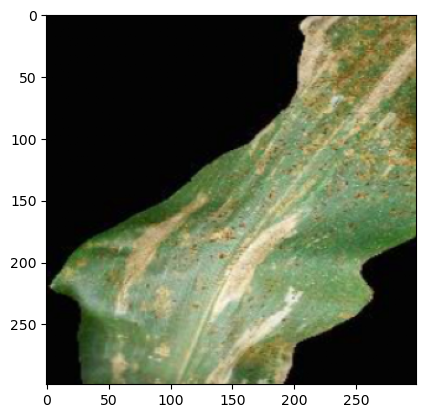

In [13]:
im, label = train_data[1000]
print(im.shape)
print("-------------")
print(label)
plt.imshow(im.permute(1,2,0).cpu())
print("Class: ",classes[label])

Class: Blight


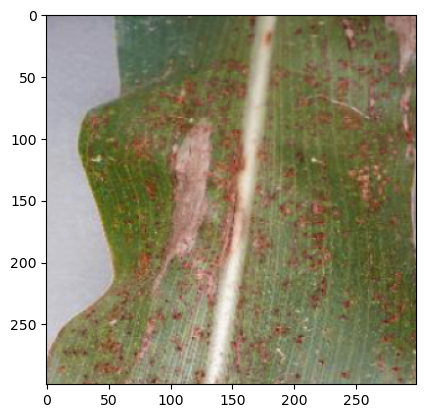

In [14]:
im, label = train_data[500]
plt.imshow(im.permute(1,2,0).cpu())
print('Class:',classes[label])

In [15]:
#descargando modelo preentreenado

model = models.inception_v3(pretrained=True)
model.parameters

<bound method Module.parameters of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2

In [16]:


def get_model():
    model = models.inception_v3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128,6))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5)
    return model.to(device), loss_fn, optimizer

In [17]:
from torchsummary import summary

input_shape = (3,299,299)
summary(model.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [18]:
# funcionn para calcular perdidas y accuracy 

def train_batch(x, y, model, opt, loss_fn):
    output = model(x)
#     print(f"type of output - {type(output)}")
    batch_loss = loss_fn(output, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [19]:
#Iniicializando modelo, Loss Fuction y Optimizer

model, loss_fn, optimizer = get_model()

In [20]:
# Entrenamiento
EPOCHS=100
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(EPOCHS):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(training_data)):

        x, y = batch

        x, y= x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)        
    print('Epoch:',epoch,'Train Loss:',train_epoch_loss,'Train Accuracy:',train_epoch_accuracy)

    for ix, batch in enumerate(iter(validation_data)):
        x, y = batch
        x, y= x.to(device), y.to(device)
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)    
        val_epoch_accuracy = np.mean(val_is_correct)

    print('Epoch:',epoch,'Validation Loss:',validation_loss,'Validation Accuracy:',val_epoch_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
Epoch: 0 Train Loss: 1.617213018811666 Train Accuracy: 0.3290264423076923
Epoch: 0 Validation Loss: 1.438268780708313 Validation Accuracy: 0.4375
1
Epoch: 1 Train Loss: 1.3323499445731823 Train Accuracy: 0.54296875
Epoch: 1 Validation Loss: 1.1318645477294922 Validation Accuracy: 0.75
2
Epoch: 2 Train Loss: 1.1397978766606405 Train Accuracy: 0.7076322115384616
Epoch: 2 Validation Loss: 0.9451790452003479 Validation Accuracy: 0.78125
3
Epoch: 3 Train Loss: 0.9965869469138292 Train Accuracy: 0.7653245192307693
Epoch: 3 Validation Loss: 0.7796945571899414 Validation Accuracy: 0.8125
4
Epoch: 4 Train Loss: 0.8824318165962513 Train Accuracy: 0.7776442307692307
Epoch: 4 Validation Loss: 0.6777263283729553 Validation Accuracy: 0.84375
5
Epoch: 5 Train Loss: 0.7888784614893106 Train Accuracy: 0.8004807692307693
Epoch: 5 Validation Loss: 0.7293903231620789 Validation Accuracy: 0.8125
6
Epoch: 6 Train Loss: 0.7155858003176175 Train Accuracy: 0.8067908653846154
Epoch: 6 Validation Loss: 0.73459

In [21]:
train_losses

[1.617213018811666,
 1.3323499445731823,
 1.1397978766606405,
 0.9965869469138292,
 0.8824318165962513,
 0.7888784614893106,
 0.7155858003176175,
 0.6563050139408845,
 0.6090522781014442,
 0.5768945389069043,
 0.5384788610614263,
 0.509298924356699,
 0.49156654798067534,
 0.4657565916960056,
 0.4494872035888525,
 0.4335143603384495,
 0.42417552837958705,
 0.4085047808117591,
 0.39938402061279005,
 0.3911628076949945,
 0.3750692567286583,
 0.3749483684794261,
 0.3633068289894324,
 0.3556612552358554,
 0.3469688059905401,
 0.3385555371642113,
 0.33765841304109645,
 0.3341667325450824,
 0.3201992248829741,
 0.32084183466549104,
 0.31717343184237295,
 0.3098412671914467,
 0.30423124951238817,
 0.30160419614269185,
 0.30191019435341543,
 0.2974584831927831,
 0.29320822634662574,
 0.29903934559283346,
 0.29367488407744813,
 0.29157709351812416,
 0.28603930957615376,
 0.28136609157977194,
 0.27887506403315526,
 0.2826171970138183,
 0.2721470250533177,
 0.2752668975064388,
 0.2722283424809575,

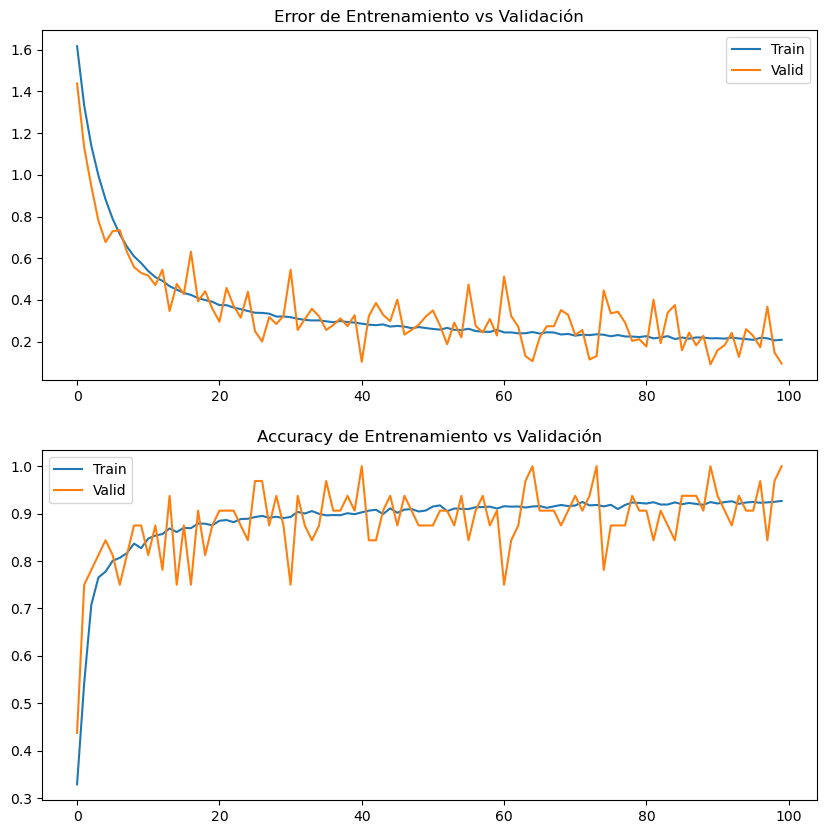

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses)
axs[0].plot(val_losses)
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_accuracies)
axs[1].plot(val_accuracies)
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [ ]:
PATH = 'Modelos_entrenados/Inception_v3_aug_final.pt'
#Modelos_entrenados
torch.save(model.state_dict(), PATH)

In [25]:
#funcion para calcular accuracy
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) 
            _, pred = scores.max(dim=1) 
            num_correct += (pred == yi).sum() 
            num_total += pred.size(0)
        return float(num_correct)/num_total

In [28]:
ac_train=accuracy(model, training_data)
ac_val=accuracy(model, validation_data)
ac_test=accuracy(model, test_data)

print(f"Accuracy Training {ac_train}")
print(f"Accuracy Validation {ac_val}")
print(f"Accuracy Testing {ac_test}")


Accuracy Training 0.9245793269230769
Accuracy Validation 0.9158653846153846
Accuracy Testing 0.8990384615384616
